In [1]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
multiprocessing.set_start_method('fork')

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import ShuffleSplit
from sklearn import metrics

# Tensorflow Stuff
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 1) Loading the simulated detector response matrix

In [2]:
# Bins to use for light yield histograma
BINS = np.linspace(1.1, 30, 101)

# Change the bins so that they fall at the midpoint of each range, 
# instead of being the beginning and end points 
bins = np.zeros(len(BINS) - 1)
for i in range(0, len(BINS) - 1):
    bins[i] = (BINS[i + 1] + BINS[i]) / 2.0
bins = np.array(bins)

In [3]:
DATADIR = "../simulate-light-yield/output/"

manager = multiprocessing.Manager()
energy_to_LY = manager.dict()

def getLY(file, energy, returnDict):
    lightYields = np.load(DATADIR + file)
    counts = np.array(plt.hist(lightYields, bins = BINS)[0])
    returnDict[energy] = counts
    
threads = []
for file in [f for f in os.listdir(DATADIR) if ".npy" in f]:
    energy = file[file.index("_") + 1:]
    energy = float(energy[0: energy.index("_")])
    threads.append(multiprocessing.Process(target = getLY, args = (file, energy, energy_to_LY)))
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

keys = list(energy_to_LY.keys())
keys.sort()
energy_to_LY = dict(energy_to_LY)

# 2) Generating neutron energy spectra from gaussian convolutions

In [4]:
xDim = len(bins)
yDim = 100

from GaussianSpectra import GaussianSpectra
x, y = GaussianSpectra(5000, yDim, bins, energy_to_LY)

# 3) Bootstrapping + Bayesian hyperparamter optimization

In [6]:
from BayesianHyperparameterOptimization import bayesian_hyperparameter_optimizer

pbounds = {
    'numNeurons0' : (830,860),
    'numNeurons1' : (590,615), 
    'numNeurons2' : (610,640), 
    'alpha0' : (0.12, 0.18), 
    'alpha1' : (0.20, 0.24), 
    'alpha2' : (0.1, 0.18),
}

optimizer = bayesian_hyperparameter_optimizer(pbounds, x, y, patience=1)
optimizer.maximize(init_points=1, n_iter=1)

print("Best Value : " , optimizer.max)

|   iter    |  target   |  alpha0   |  alpha1   |  alpha2   | numNeu... | numNeu... | numNeu... |
-------------------------------------------------------------------------------------------------


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.12/site-packages/bayes_opt/target_space.py:344: UserWarning: You're attempting to register an np.ndarray. Currently, the optimizer internally sorts parameters by key and expects any registered array to respect this order. In future versions this behaviour will change and the order as given by the pbounds dictionary will be used. If you wish to retain sorted parameters, please manually sort your pbounds dictionary before constructing the optimizer.
  warn(msg, stacklevel=1)


| 1         | -0.1767   | 0.1425    | 0.238     | 0.1586    | 848.0     | 593.9     | 614.7     |
| 2         | -0.2131   | 0.1294    | 0.2023    | 0.1693    | 848.0     | 607.7     | 610.6     |
Best Value :  {'target': -0.17671152474719662, 'params': {'alpha0': 0.14247240713084175, 'alpha1': 0.23802857225639665, 'alpha2': 0.15855951534491242, 'numNeurons0': 847.9597545259111, 'numNeurons1': 593.9004660110609, 'numNeurons2': 614.6798356100861}}


# 4) Train neural network from optimal hyperparameters

In [7]:
# From past hyperparamter optimization
Best = {'target': -0.0633033906734846, 'params': {'alpha0': 0.13117561268266026, 'alpha1': 0.21382242908172192, 'alpha2': 0.1317413979384536, 'numNeurons0': 846.1645020201007, 'numNeurons1': 600.4798628600823, 'numNeurons2': 630.5565850119028}}
alpha0 = Best['params']['alpha0']
alpha1 = Best['params']['alpha1']
alpha2 = Best['params']['alpha2']
numNeurons0 = Best['params']['numNeurons0']
numNeurons1 = Best['params']['numNeurons1']
numNeurons2 = Best['params']['numNeurons2']

from UnfoldingNeuralNetwork import get_model
model = get_model(xDim, yDim, numNeurons0, numNeurons1, numNeurons2, alpha0, alpha1, alpha2)

model.compile(loss = "mse", optimizer = Adam())
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-8, 
                        patience=20, verbose=2,
                        mode='min', restore_best_weights=True)

model.fit(x, y * 1e4, validation_split=0.2, batch_size = 120, callbacks=[monitor], verbose=2, epochs=10000)

Epoch 1/10000
34/34 - 1s - 22ms/step - loss: 1.1535 - val_loss: 0.8241
Epoch 2/10000
34/34 - 0s - 7ms/step - loss: 0.6636 - val_loss: 0.4817
Epoch 3/10000
34/34 - 0s - 7ms/step - loss: 0.4353 - val_loss: 0.3541
Epoch 4/10000
34/34 - 0s - 7ms/step - loss: 0.3396 - val_loss: 0.3023
Epoch 5/10000
34/34 - 0s - 7ms/step - loss: 0.2844 - val_loss: 0.2620
Epoch 6/10000
34/34 - 0s - 7ms/step - loss: 0.2425 - val_loss: 0.2217
Epoch 7/10000
34/34 - 0s - 7ms/step - loss: 0.2163 - val_loss: 0.2029
Epoch 8/10000
34/34 - 0s - 8ms/step - loss: 0.1928 - val_loss: 0.1982
Epoch 9/10000
34/34 - 0s - 10ms/step - loss: 0.1857 - val_loss: 0.1669
Epoch 10/10000
34/34 - 0s - 10ms/step - loss: 0.1678 - val_loss: 0.1597
Epoch 11/10000
34/34 - 0s - 8ms/step - loss: 0.1647 - val_loss: 0.1539
Epoch 12/10000
34/34 - 0s - 8ms/step - loss: 0.1590 - val_loss: 0.1507
Epoch 13/10000
34/34 - 0s - 7ms/step - loss: 0.1515 - val_loss: 0.1455
Epoch 14/10000
34/34 - 0s - 7ms/step - loss: 0.1489 - val_loss: 0.1457
Epoch 15/100

KeyboardInterrupt: 

# 5) Performance of unfolding neural network on simulated data

In [8]:
x_test, y_test = GaussianSpectra(5000, yDim, bins, energy_to_LY)
y_test = y_test * 1e4
energyBins = np.linspace(1, 20000, yDim)
i = 0

<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
/var/folders/66/dcsv62x14w98n4s5n8mdhpvc0000gn/T/ipykernel_6019/3780431005.py:6: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel("Normalized dN/dE ($\int \phi(E)\;dE $ = 1)")


Text(0.5, 1.0, 'Example Unfolded Spectra')

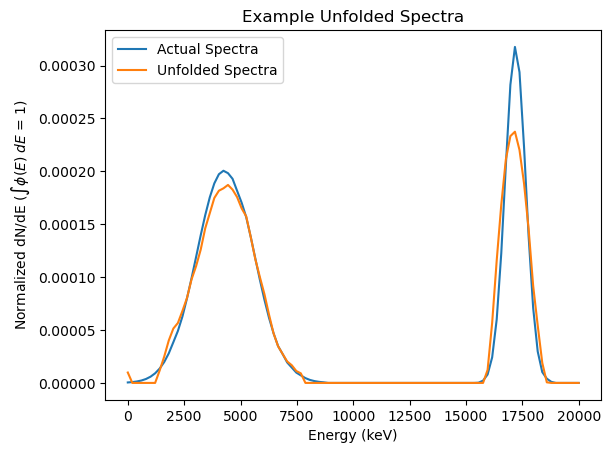

In [11]:
i += 1
plt.plot(energyBins, y_test[i] / 1e4, label = "Actual Spectra")
plt.plot(energyBins, model(x_test)[i] / 1e4, label = "Unfolded Spectra")
plt.legend()
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized dN/dE ($\int \phi(E)\;dE $ = 1)")
plt.title("Example Unfolded Spectra")

<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
/var/folders/66/dcsv62x14w98n4s5n8mdhpvc0000gn/T/ipykernel_6019/2802538938.py:3: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel("Proportion Density ($\int L$ = 1)")


(0.0, 31.0)

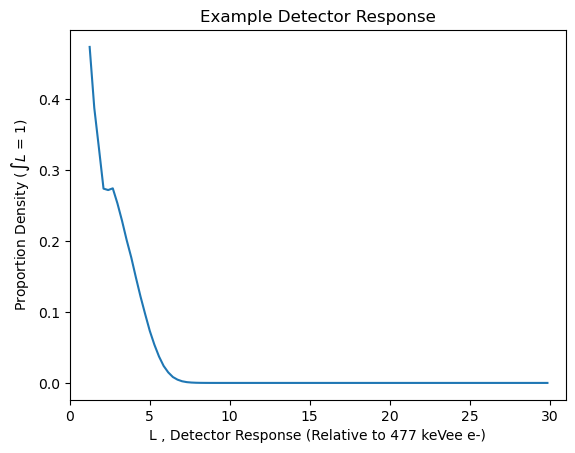

In [12]:
plt.plot(bins, x_test[10])
plt.xlabel("L , Detector Response (Relative to 477 keVee e-)")
plt.ylabel("Proportion Density ($\int L$ = 1)")
plt.title("Example Detector Response")
plt.xlim(0, 31)

# 6) Performance of unfolding neural network on real-world experimental data

In [27]:
from scipy import interpolate
from ExperimentalData import load_experimental_data, UnprocessedCF252DetectorResponse, UnprocessedAmBe241DetectorResponse, UnprocessedCF252EnergySpectra, UnprocessedAmBe241EnergySpectra
AmBe241DetectorResponse, AmBe241EnergySpectra, CF252DetectorResponse, CF252EnergySpectra = load_experimental_data(bins)

In [28]:
# Normalizes the data
def normalize(bins,counts):
    width = bins[1] - bins[0]
    counts = counts / ( width * sum(counts) )
    return counts

# Gets the simulated detector response from a given energy spectra
def getX(yRow, energyToLY, keys):
    xRow = np.zeros(xDim)
    for index in range(yDim):
        xRow += yRow[index] * energyToLY[keys[index]]        
    return normalize(bins,xRow)

Text(0.5, 1.0, 'Real-World Detector Response, interpolated into 100 buckets')

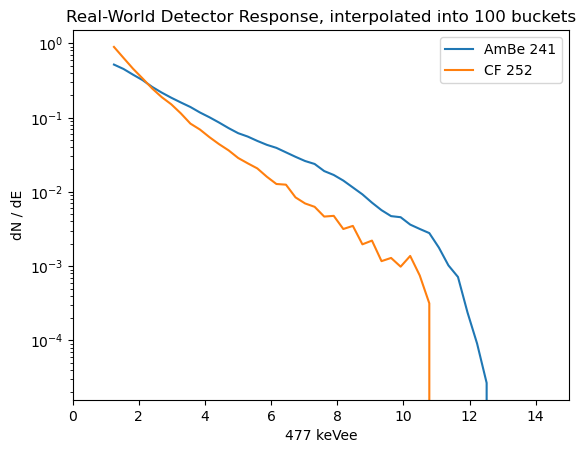

In [29]:
plt.plot(bins, AmBe241DetectorResponse, label="AmBe 241")
plt.plot(bins, CF252DetectorResponse, label="CF 252")
plt.yscale("log")
plt.legend()
plt.xlim(0, 15)
plt.xlabel("477 keVee")
plt.ylabel("dN / dE")
plt.title("Real-World Detector Response, interpolated into 100 buckets")

Text(0.5, 1.0, 'Real-World Neutron Energy Spectra, interpolated into 100 buckets')

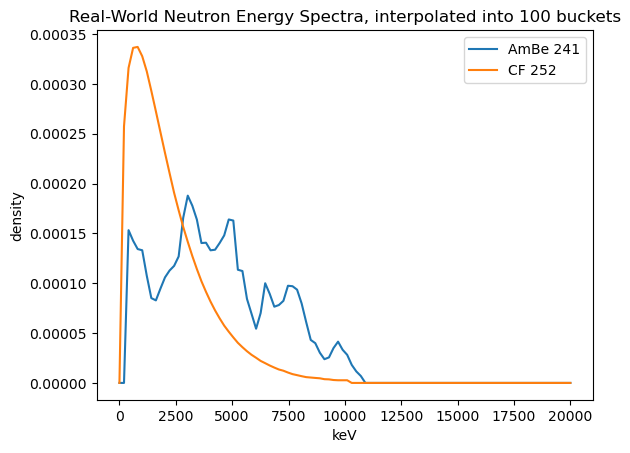

In [30]:
plt.plot(energyBins, AmBe241EnergySpectra, label="AmBe 241")
plt.plot(energyBins, CF252EnergySpectra, label="CF 252")
plt.legend()
plt.xlabel("keV")
plt.ylabel("density")
plt.title("Real-World Neutron Energy Spectra, interpolated into 100 buckets")

Text(0.5, 1.0, 'Actual Detector Response vs Simulation for CF 252')

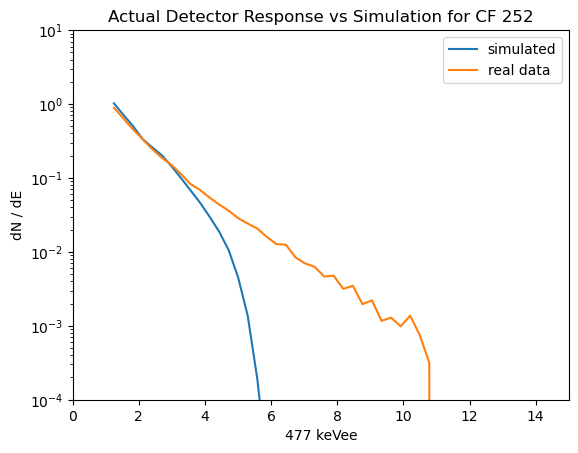

In [31]:
yCF252 = interpolate.interp1d(*UnprocessedCF252EnergySpectra, fill_value='extrapolate', bounds_error=False)(np.linspace(1,20000,400) / 1000)
yCF252 = [y if y > 0 else 0 for y in yCF252]
yCF252 = yCF252 / sum(yCF252)

plt.plot(bins, getX(yCF252, energy_to_LY, keys), label = "simulated")
plt.plot(bins, CF252DetectorResponse, label = "real data")
plt.yscale("log")
plt.legend()
plt.xlabel("477 keVee")
plt.ylabel("dN / dE")
plt.ylim(1e-4, 10)
plt.xlim(0, 15)
plt.title("Actual Detector Response vs Simulation for CF 252")

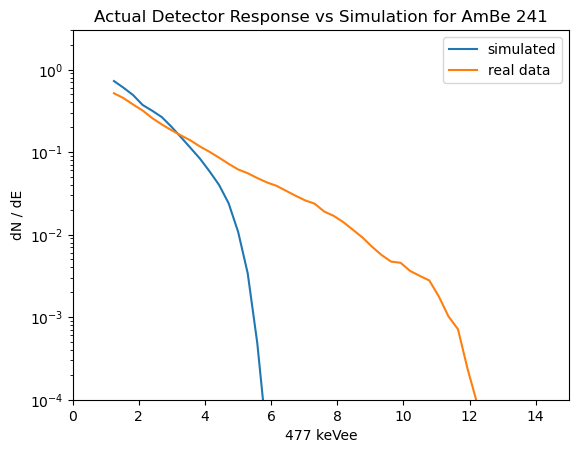

In [33]:
yAmBe241 = interpolate.interp1d(*UnprocessedAmBe241EnergySpectra, fill_value='extrapolate', bounds_error=False)(np.linspace(1,20000,400) / 1000)
yAmBe241 = [y if y > 0 else 0 for y in yAmBe241]
yAmBe241 = yAmBe241 / sum(yAmBe241)

plt.plot(bins, getX(yAmBe241, energy_to_LY, keys), label = "simulated")
plt.plot(bins, AmBe241DetectorResponse, label = "real data")
plt.yscale("log")
plt.ylim(1e-4, 3e0)
plt.xlim(0,15)
plt.xlabel("477 keVee")
plt.ylabel("dN / dE")
plt.title("Actual Detector Response vs Simulation for AmBe 241")
plt.legend()

Text(0.5, 1.0, 'Performance of NN on CF 252')

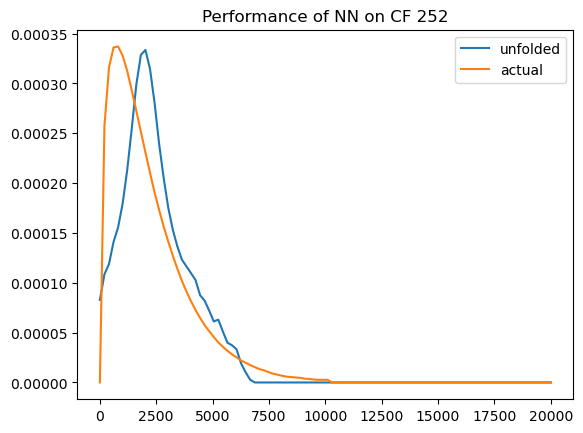

In [37]:
plt.plot(energyBins, model(np.array([CF252DetectorResponse]))[0] / 1e4, label = "unfolded")
plt.plot(energyBins, CF252EnergySpectra, label = "actual")
plt.legend()
plt.title("Performance of NN on CF 252")


Text(0.5, 1.0, 'Performance of NN on AmBe 241')

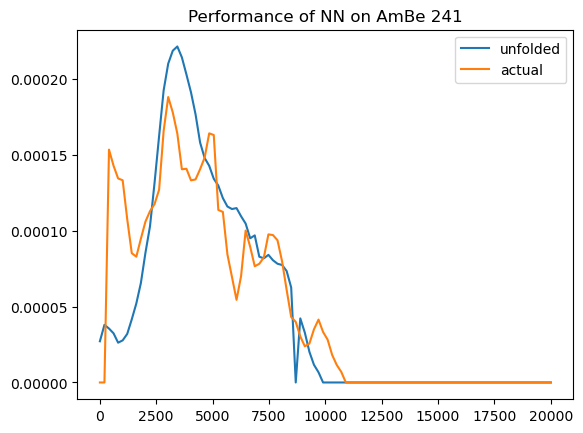

In [38]:
plt.plot(energyBins, model(np.array([AmBe241DetectorResponse]))[0] / 1e4, label = "unfolded")
plt.plot(energyBins, AmBe241EnergySpectra, label = "actual")
plt.legend()
plt.title("Performance of NN on AmBe 241")